### 70. 単語ベクトルの和による特徴量

データを読み込んで単語に分割する

In [1]:
import re
import spacy

In [2]:
nlp = spacy.load('en')
categories = ['b', 't', 'e', 'm']
category_names = ['business', 'science and technology', 'entertainment', 'health']

In [3]:
def tokenize(x):
    x = re.sub(r'\s+', ' ', x)
    x = nlp.make_doc(x)
    x = [d.text for d in x]
    return x

def read_feature_dataset(filename):
    with open(filename) as f:
        dataset = f.read().splitlines()
    dataset = [line.split('\t') for line in dataset]
    dataset_t = [categories.index(line[0]) for line in dataset]
    dataset_x = [tokenize(line[1]) for line in dataset]
    return dataset_x, dataset_t

In [4]:
train_x, train_t = read_feature_dataset('data/train.txt')
valid_x, valid_t = read_feature_dataset('data/valid.txt')
test_x, test_t = read_feature_dataset('data/test.txt')

特徴ベクトルに変換する

In [5]:
import torch
from gensim.models import KeyedVectors

unable to import 'smart_open.gcs', disabling that module


In [6]:
model = KeyedVectors.load_word2vec_format('data/GoogleNews-vectors-negative300.bin.gz', binary=True)

In [7]:
def sent_to_vector(sent):
    lst = [torch.tensor(model[token]) for token in sent if token in model]
    return sum(lst) / len(lst)

def dataset_to_vector(dataset):
    return torch.stack([sent_to_vector(x) for x in dataset])

In [8]:
train_v = dataset_to_vector(train_x)
valid_v = dataset_to_vector(valid_x)
test_v = dataset_to_vector(test_x)

In [9]:
train_v[0]

tensor([ 9.0576e-02,  5.4932e-02, -7.7393e-02,  1.1810e-01, -3.8849e-02,
        -2.6074e-01, -6.4484e-02,  3.2715e-02,  1.1792e-01, -3.4363e-02,
        -1.5137e-02, -1.7090e-02,  7.2632e-02,  1.0742e-02,  1.1194e-01,
         5.8945e-02,  1.6275e-01,  1.5393e-01,  7.0496e-02, -1.5210e-01,
         2.8320e-02,  1.1719e-02,  1.9702e-01, -1.5610e-02, -2.3438e-02,
         1.8921e-02,  2.8687e-02, -2.3438e-02,  2.3315e-02, -5.7480e-02,
         2.1973e-03, -1.0449e-01, -9.7534e-02, -1.3694e-01,  1.6144e-01,
        -2.6062e-02,  3.1250e-02,  1.9482e-01, -1.0788e-01,  7.2571e-02,
        -1.3916e-02,  1.1121e-01,  7.0801e-03, -4.1016e-02, -1.9580e-01,
         1.7334e-02,  1.0986e-02, -6.9485e-03,  9.2773e-02,  7.2205e-02,
         6.8298e-02, -5.3589e-02, -1.7447e-01,  1.0245e-01, -8.6426e-02,
        -9.0942e-03, -1.7212e-01, -1.3789e-01, -1.0355e-01,  1.9226e-02,
         1.0620e-02,  9.7626e-02, -5.1147e-02,  1.1371e-01,  3.5156e-02,
        -4.8523e-03, -7.1960e-02,  1.1841e-01, -1.0

pickleにして保存

In [10]:
import pickle

In [11]:
train_t = torch.tensor(train_t).long()
valid_t = torch.tensor(valid_t).long()
test_t = torch.tensor(test_t).long()

In [12]:
with open('data/train.feature.pickle', 'wb') as f:
    pickle.dump(train_v, f)
with open('data/train.label.pickle', 'wb') as f:
    pickle.dump(train_t, f)
    
with open('data/valid.feature.pickle', 'wb') as f:
    pickle.dump(valid_v, f)
with open('data/valid.label.pickle', 'wb') as f:
    pickle.dump(valid_t, f)
    
with open('data/test.feature.pickle', 'wb') as f:
    pickle.dump(test_v, f)
with open('data/test.label.pickle', 'wb') as f:
    pickle.dump(test_t, f)

### 71. 単層ニューラルネットワークによる予測

出題意図としては，単なる行列にsoftmaxかけたり，後々backwardしたりするというものなのかもしれませんが，ここではnn.Moduleを継承するクラスを作っていきます．

In [13]:
import torch.nn as nn

In [14]:
class Perceptron(nn.Module):
    def __init__(self, v_size, c_size):
        super().__init__()
        self.fc = nn.Linear(v_size, c_size, bias = False)
        nn.init.xavier_normal_(self.fc.weight)
        
    def forward(self, x):
        x = self.fc(x)
        return x

In [15]:
model = Perceptron(300, 4)

In [16]:
x = model(train_v[0])
x = torch.softmax(x, dim=-1)
x

tensor([0.2649, 0.2338, 0.2063, 0.2950], grad_fn=<SoftmaxBackward>)

In [17]:
x = model(train_v[:4])
x = torch.softmax(x, dim=-1)
x

tensor([[0.2649, 0.2338, 0.2063, 0.2950],
        [0.2447, 0.2445, 0.2552, 0.2556],
        [0.2793, 0.2485, 0.2185, 0.2537],
        [0.2724, 0.2673, 0.2438, 0.2165]], grad_fn=<SoftmaxBackward>)

### 72. 損失と勾配の計算

In [18]:
criterion = nn.CrossEntropyLoss()

In [19]:
y = model(train_v[:1])
t = train_t[:1]
loss = criterion(y, t)
model.zero_grad()
loss.backward()
print('損失 :', loss.item())
print('勾配')
print(model.fc.weight.grad)

損失 : 1.2207489013671875
勾配
tensor([[ 0.0240,  0.0146, -0.0205,  ...,  0.0314,  0.0321, -0.0047],
        [ 0.0212,  0.0128, -0.0181,  ...,  0.0277,  0.0284, -0.0041],
        [ 0.0187,  0.0113, -0.0160,  ...,  0.0245,  0.0250, -0.0036],
        [-0.0639, -0.0387,  0.0546,  ..., -0.0836, -0.0855,  0.0124]])


In [20]:
model.zero_grad()
model.fc.weight.grad

tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])

In [21]:
y = model(train_v[:4])
t = train_t[:4]
loss = criterion(y, t)
model.zero_grad()
loss.backward()
print('損失 :', loss.item())
print('勾配')
print(model.fc.weight.grad)

損失 : 1.3190146684646606
勾配
tensor([[ 0.0041,  0.0011, -0.0137,  ...,  0.0093,  0.0158, -0.0021],
        [-0.0014,  0.0031, -0.0080,  ...,  0.0072,  0.0106, -0.0009],
        [ 0.0038,  0.0010, -0.0094,  ...,  0.0079,  0.0142, -0.0014],
        [-0.0065, -0.0053,  0.0311,  ..., -0.0244, -0.0406,  0.0044]])


### 73. 確率的勾配降下法による学習

確率的勾配降下なので，データセットをシャッフルして少しずつ取り出すようにします

データを持ってるのがDataset

In [22]:
class Dataset(torch.utils.data.Dataset):
    def __init__(self, x, t):
        self.x = x
        self.t = t
        self.size = len(x)
    
    def __len__(self):
        return self.size
            
    def __getitem__(self, index):
        return {
            'x':self.x[index],
            't':self.t[index],
        }

データセットをバッチに分割してバッチのインデックスを返すのがSampler

In [23]:
class Sampler(torch.utils.data.Sampler):
    def __init__(self, dataset, width, shuffle=False):
        self.dataset = dataset
        self.width = width
        self.shuffle = shuffle
        if not shuffle:
            self.indices = torch.arange(len(dataset))
    
    def __iter__(self):
        if self.shuffle:
            self.indices = torch.randperm(len(self.dataset))
        index = 0
        while index < len(self.dataset):
            yield self.indices[index : index + self.width]
            index += self.width

DatasetとSamplerをDataLoaderに渡すと，データセットをシャッフルして少しずつ取り出すことができる

In [24]:
def gen_loader(dataset, width, sampler=Sampler, shuffle=False, num_workers=8):
    return torch.utils.data.DataLoader(
        dataset, 
        batch_sampler = sampler(dataset, width, shuffle),
        num_workers = num_workers,
    )

データセットをバッチに積んでiterableにするの，人々が好きにいろんな方法でやっていて，どうやるのが適切なのかよくわかんない．

個人的にはDatasetにデータ置いておいて，Samplerでインデックスをバッチに切り分けて，Loaderで回すっていうのが一番わかりやすいんじゃないかとは思っている　謎

In [25]:
train_dataset = Dataset(train_v, train_t)
valid_dataset = Dataset(valid_v, valid_t)
test_dataset = Dataset(test_v, test_t)
loaders = (
    gen_loader(train_dataset, 1, shuffle = True),
    gen_loader(valid_dataset, 1),
)

損失を計算するTaskと最適化を回すTrainer

In [26]:
import torch.optim as optim

In [27]:
class Task:
    def __init__(self):
        self.criterion = nn.CrossEntropyLoss()
    
    def train_step(self, model, batch):
        model.zero_grad()
        loss = self.criterion(model(batch['x']), batch['t'])
        loss.backward()
        return loss.item()
    
    def valid_step(self, model, batch):
        with torch.no_grad():
            loss = self.criterion(model(batch['x']), batch['t'])
        return loss.item()

In [28]:
class Trainer:
    def __init__(self, model, loaders, task, optimizer, max_iter, device = None):
        self.model = model
        self.model.to(device)
        self.train_loader, self.valid_loader = loaders
        self.task = task
        self.max_iter = max_iter
        self.optimizer = optimizer
        self.device = device
    
    def send(self, batch):
        for key in batch:
            batch[key] = batch[key].to(self.device)
        return batch
        
    def train_epoch(self):
        self.model.train()
        acc = 0
        for n, batch in enumerate(self.train_loader):
            batch = self.send(batch)
            acc += self.task.train_step(self.model, batch)
            self.optimizer.step()
        return acc / n
            
    def valid_epoch(self):
        self.model.eval()
        acc = 0
        for n, batch in enumerate(self.valid_loader):
            batch = self.send(batch)
            acc += self.task.valid_step(self.model, batch)
        return acc / n
    
    def train(self):
        for epoch in range(self.max_iter):
            train_loss = self.train_epoch()
            valid_loss = self.valid_epoch()
            print('epoch {}, train_loss:{:.5f}, valid_loss:{:.5f}'.format(epoch, train_loss, valid_loss))

In [29]:
model = Perceptron(300, 4)
task = Task()
optimizer = optim.SGD(model.parameters(), 0.1)
trainer = Trainer(model, loaders, task, optimizer, 10)
trainer.train()

epoch 0, train_loss:0.40386, valid_loss:0.32911
epoch 1, train_loss:0.29639, valid_loss:0.30293
epoch 2, train_loss:0.27472, valid_loss:0.29529
epoch 3, train_loss:0.26203, valid_loss:0.29824
epoch 4, train_loss:0.25422, valid_loss:0.29405
epoch 5, train_loss:0.24754, valid_loss:0.30147
epoch 6, train_loss:0.24355, valid_loss:0.30236
epoch 7, train_loss:0.24011, valid_loss:0.30972
epoch 8, train_loss:0.23713, valid_loss:0.31401
epoch 9, train_loss:0.23473, valid_loss:0.31417


### 74. 正解率の計測

In [30]:
import numpy as np

In [31]:
class Predictor:
    def __init__(self, model, loader):
        self.model = model
        self.loader = loader
        
    def infer(self, batch):
        self.model.eval()
        return self.model(batch['x']).argmax(dim=-1).item()
        
    def predict(self):
        lst = []
        for batch in self.loader:
            lst.append(self.infer(batch))
        return lst

In [32]:
def accuracy(true, pred):
    return np.mean([t == p for t, p in zip(true, pred)])

In [33]:
predictor = Predictor(model, gen_loader(train_dataset, 1))
pred = predictor.predict()
print('学習データでの正解率 :', accuracy(train_t, pred))

学習データでの正解率 : 0.9228753275926619


In [34]:
predictor = Predictor(model, gen_loader(test_dataset, 1))
pred = predictor.predict()
print('評価データでの正解率 :', accuracy(test_t, pred))

評価データでの正解率 : 0.9011976047904192


### 75. 損失と正解率のプロット

In [35]:
import matplotlib.pyplot as plt
import japanize_matplotlib
from IPython.display import clear_output

/home/koyama.s/nlp100/env/nlp100/lib/python3.8/site-packages/japanize_matplotlib/__init__.py:13: MatplotlibDeprecationWarning: 
The createFontList function was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use FontManager.addfont instead.
  font_list = font_manager.createFontList(font_files)


In [36]:
class RealTimePlot:
    def __init__(self, legends):
        self.legends = legends
        self.fig, self.axs = plt.subplots(1, len(legends), figsize = (10, 5))
        self.lst = [[[] for _ in xs] for xs in legends]
        
    def __enter__(self):
        return self
        
    def update(self, *args):
        for i, ys in enumerate(args):
            for j, y in enumerate(ys):
                self.lst[i][j].append(y)
        clear_output(wait = True)
        for i, ax in enumerate(self.axs):
            ax.cla()
            for ys in self.lst[i]:
                ax.plot(ys)
            ax.legend(self.legends[i])
        display(self.fig)
        
    def __exit__(self, *exc_info):
        plt.close(self.fig)

In [37]:
class VerboseTrainer(Trainer):
    def accuracy(self, true, pred):
        return np.mean([t == p for t, p in zip(true, pred)])
    
    def train(self, train_v, train_t, valid_v, valid_t):
        train_loader = gen_loader(Dataset(train_v, train_t), 1)
        valid_loader = gen_loader(Dataset(valid_v, valid_t), 1)
        with RealTimePlot([['学習', '検証']] * 2) as rtp:
            for epoch in range(self.max_iter):
                self.model.to(self.device)
                train_loss = self.train_epoch()
                valid_loss = self.valid_epoch()
                train_acc = self.accuracy(train_t, Predictor(self.model.cpu(), train_loader).predict())
                valid_acc = self.accuracy(valid_t, Predictor(self.model.cpu(), valid_loader).predict())
                rtp.update([train_loss, valid_loss], [train_acc, valid_acc])

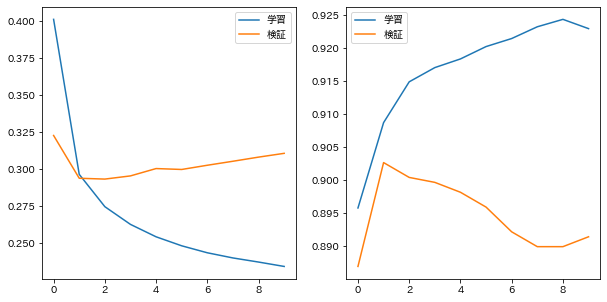

In [38]:
model = Perceptron(300, 4)
task = Task()
optimizer = optim.SGD(model.parameters(), 0.1)
trainer = VerboseTrainer(model, loaders, task, optimizer, 10)
train_predictor = Predictor(model, gen_loader(test_dataset, 1))
valid_predictor = Predictor(model, gen_loader(test_dataset, 1))
trainer.train(train_v, train_t, valid_v, valid_t)

### 76. チェックポイント

問題75から改変してもいいけど，めんどうなので73からやる

In [39]:
import os

In [40]:
class LoggingTrainer(Trainer):
    def save(self, epoch):
        torch.save({'epoch' : epoch, 'optimizer': self.optimizer}, f'trainer_states{epoch}.pt')
        torch.save(self.model.state_dict(), f'checkpoint{epoch}.pt')
    
    def train(self):
        for epoch in range(self.max_iter):
            train_loss = self.train_epoch()
            valid_loss = self.valid_epoch()
            self.save(epoch)
            print('epoch {}, train_loss:{:.5f}, valid_loss:{:.5f}'.format(epoch, train_loss, valid_loss))

In [41]:
model = Perceptron(300, 4)
task = Task()
optimizer = optim.SGD(model.parameters(), 0.1)
trainer = LoggingTrainer(model, loaders, task, optimizer, 10)
trainer.train()

epoch 0, train_loss:0.40108, valid_loss:0.31714
epoch 1, train_loss:0.29624, valid_loss:0.29827
epoch 2, train_loss:0.27350, valid_loss:0.30317
epoch 3, train_loss:0.26214, valid_loss:0.29738
epoch 4, train_loss:0.25384, valid_loss:0.29715
epoch 5, train_loss:0.24793, valid_loss:0.30123
epoch 6, train_loss:0.24324, valid_loss:0.30546
epoch 7, train_loss:0.24004, valid_loss:0.30552
epoch 8, train_loss:0.23729, valid_loss:0.31072
epoch 9, train_loss:0.23428, valid_loss:0.31627


In [42]:
! ls result/checkpoint*

result/checkpoint0.pt  result/checkpoint4.pt  result/checkpoint8.pt
result/checkpoint1.pt  result/checkpoint5.pt  result/checkpoint9.pt
result/checkpoint2.pt  result/checkpoint6.pt
result/checkpoint3.pt  result/checkpoint7.pt


In [43]:
! ls result/trainer_states*

result/trainer_states0.pt  result/trainer_states4.pt  result/trainer_states8.pt
result/trainer_states1.pt  result/trainer_states5.pt  result/trainer_states9.pt
result/trainer_states2.pt  result/trainer_states6.pt
result/trainer_states3.pt  result/trainer_states7.pt


### 77. ミニバッチ化

In [44]:
from time import time
from contextlib import contextmanager

In [45]:
@contextmanager
def timer(description):
    start = time()
    yield
    print(description, ': {:.3f} 秒'.format(time()-start))

In [46]:
B = [1, 2, 4, 8, 16, 32, 64, 128, 256, 512, 1024]

In [47]:
task = Task()
for b in B:
    model = Perceptron(300, 4)
    loaders = (
        gen_loader(train_dataset, b, shuffle = True),
        gen_loader(valid_dataset, 1)
    )
    optimizer = optim.SGD(model.parameters(), 0.1 * b)
    trainer = Trainer(model, loaders, task, optimizer, 3)
    with timer(f'バッチサイズ {b}'):
        trainer.train()

epoch 0, train_loss:0.40192, valid_loss:0.31378
epoch 1, train_loss:0.29552, valid_loss:0.29793
epoch 2, train_loss:0.27417, valid_loss:0.29233
バッチサイズ 1 : 24.519 秒
epoch 0, train_loss:0.40131, valid_loss:0.31468
epoch 1, train_loss:0.29680, valid_loss:0.29696
epoch 2, train_loss:0.27444, valid_loss:0.30022
バッチサイズ 2 : 13.708 秒
epoch 0, train_loss:0.40070, valid_loss:0.31462
epoch 1, train_loss:0.29644, valid_loss:0.30806
epoch 2, train_loss:0.27426, valid_loss:0.30391
バッチサイズ 4 : 8.289 秒
epoch 0, train_loss:0.40054, valid_loss:0.31235
epoch 1, train_loss:0.29526, valid_loss:0.29831
epoch 2, train_loss:0.27453, valid_loss:0.29417
バッチサイズ 8 : 5.553 秒
epoch 0, train_loss:0.40306, valid_loss:0.31765
epoch 1, train_loss:0.29657, valid_loss:0.30124
epoch 2, train_loss:0.27443, valid_loss:0.29690
バッチサイズ 16 : 4.205 秒
epoch 0, train_loss:0.40460, valid_loss:0.31006
epoch 1, train_loss:0.29744, valid_loss:0.29631
epoch 2, train_loss:0.27558, valid_loss:0.29507
バッチサイズ 32 : 3.444 秒
epoch 0, train_los

### 78. GPU上での学習

In [48]:
device = torch.device('cuda')
model = Perceptron(300, 4)
task = Task()
loaders = (
    gen_loader(train_dataset, 128, shuffle = True),
    gen_loader(valid_dataset, 1),
)
optimizer = optim.SGD(model.parameters(), 0.1 * 128)
trainer = Trainer(model, loaders, task, optimizer, 3, device=device)
with timer('時間'):
    trainer.train()

epoch 0, train_loss:0.42075, valid_loss:0.34151
epoch 1, train_loss:0.30337, valid_loss:0.31785
epoch 2, train_loss:0.27851, valid_loss:0.29864
時間 : 23.363 秒


### 79. 多層ニューラルネットワーク

In [49]:
class ModelNLP79(nn.Module):
    def __init__(self, v_size, h_size, c_size):
        super().__init__()
        self.fc1 = nn.Linear(v_size, h_size)
        self.act = nn.ReLU()
        self.fc2 = nn.Linear(h_size, c_size)
        self.dropout = nn.Dropout(0.2)
        nn.init.kaiming_normal_(self.fc1.weight)
        nn.init.kaiming_normal_(self.fc2.weight)
        
    def forward(self, x):
        x = self.fc1(x)
        x = self.act(x)
        x = self.dropout(x)
        x = self.fc2(x)
        return x

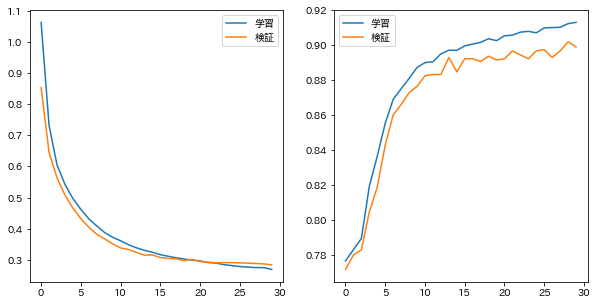

In [50]:
model = ModelNLP79(300, 128, 4)
task = Task()
loaders = (
    gen_loader(train_dataset, 128, shuffle = True),
    gen_loader(valid_dataset, 1)
)
optimizer = optim.SGD(model.parameters(), 0.1)
trainer = VerboseTrainer(model, loaders, task, optimizer, 30, device)
trainer.train(train_v, train_t, valid_v, valid_t)